In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from collections import defaultdict as dd
from nltk.probability import FreqDist as fd
import dill as pickle
import numpy as np
from numpy.linalg import norm
from scipy.stats import entropy as H
from itertools import combinations
from collections import defaultdict as dd

In [2]:
#adapted from alemol @ https://stackoverflow.com/questions/15880133/jensen-shannon-divergence
#identical dists have divergence of zero
def JSD(prob_distributions, weights, dist_weights, logbase=2):
    # left term: entropy of mixture
    wprobs = weights * prob_distributions
    mixture = wprobs.sum(axis=0)
    entropy_of_mixture = H(mixture, base=logbase)

    # right term: sum of entropies
    entropies = np.array([H(P_i, base=logbase) for P_i in prob_distributions])
    wentropies = dist_weights * entropies
    sum_of_entropies = wentropies.sum()

    divergence = entropy_of_mixture - sum_of_entropies
    return(divergence)

In [95]:
sample_dist1=np.array([0.2,0.4,0.4])
sample_dist2=np.array([1/3,1/3,1/3])
sample_dist3=np.array([0.4,0.3,0.3])
weights=np.array([1/3]*3)
JSD([sample_dist1,sample_dist2,sample_dist3], weights)

0.02406037673528827

In [207]:
direc="/home/benjamin/sfi/project_stuff/data/clean/"
months=["Jan", "Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
site_list=["atlantic","breitbart","thehill","motherjones"]
year="2016"
d=[[] for x in range(7)]
for month in months:
    f=open(direc+month+year+"stats.pkl","rb")
    a=pickle.load(f)
    words=set()
    for site in site_list:
        words=words.union(set(a[0][site][year][month].keys()))
    probs=[[a[0][site][year][month].freq(word) for word in words] for site in site_list]
    for a,i in enumerate(combinations(range(4),2)):
        j,k=i
        p_dists=np.array([probs[j],probs[k]])
        n=len(probs[0])
        weights=np.empty(n)
        weights.fill(1/n)
        dist_weights=[1/len(p_dists)]*len(p_dists)
        d[a].append(JSD(p_dists,weights,dist_weights))
    p_dists=np.array(probs)
    n=len(probs[0])
    weights=np.empty(n)
    weights.fill(1/n)
    dist_weights=[1/len(p_dists)]*len(p_dists)
    d[6].append(JSD(p_dists,weights,dist_weights))
    f.close()

In [3]:
direc="/home/benjamin/sfi/project_stuff/data/cleaner/"
months=["Jan", "Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
site_list=["atlantic","breitbart","thehill","motherjones"]
year="2016"
#site, year, month, word, POS
p_dists=dd(lambda: dd(lambda: dd(lambda: dd(fd))))
for month in months:
    with open(direc+month+year+"stats.pkl","rb") as f:
        a=pickle.load(f)
        for site in site_list:
            p_dists[site][year][month]=a[1][site][year][month]


In [18]:
year="2016"
n=["NN","NNP","NNPS","NNS"]
a=["JJ","JJR","JJS"]
noun_p=dd(lambda: dd(lambda: [None]*12))
adj_p=dd(lambda: dd(lambda: [None]*12))
other_p=dd(lambda: dd(lambda: [None]*12))
for site in site_list:
    for i, month in enumerate(months):
        for word in p_dists[site]["2016"][month].keys():
            noun_p[site][word][i]=sum([p_dists[site]["2016"][month][word].freq(p) for p in n])
            adj_p[site][word][i]=sum([p_dists[site]["2016"][month][word].freq(p) for p in a])
            other_p[site][word][i]=sum([p_dists[site]["2016"][month][word].freq(p) for p in p_dists[site]["2016"][month][word].keys() if p not in n and p not in a])


In [ ]:
with open("POSstats.pkl", "wb") as f:
    pickle.dump([noun_p, adj_p, other_p], f)

In [22]:
noun_p["motherjones"]["black"]

[0.19726678550207963,
 0.22376060741402412,
 0.22356020942408375,
 0.21094369547977795,
 0.20603015075376882,
 0.22210414452709884,
 0.2787630741246021,
 0.37727558066541117,
 0.23221757322175732,
 0.2282051282051282,
 0.28015873015873016,
 0.2872340425531915]

In [23]:
noun_p["breitbart"]["black"]

[0.2714805318704907,
 0.28645111197382284,
 0.3301617507136061,
 0.29943352215928026,
 0.29062155204119167,
 0.26027610950783875,
 0.29518467689002925,
 0.2875243664717349,
 0.2790991612087786,
 0.27478567826525463,
 0.27351265703399097,
 0.2529466295854853]

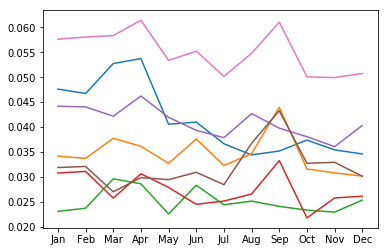

In [210]:
for i in d:
    plt.plot(months,i)